In [ ]:
import itertools
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, calinski_harabasz_score, silhouette_score
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, f1_score, hamming_loss
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
import spacy, en_core_web_sm
nlp=en_core_web_sm.load()
from itertools import chain
#!pip install --upgrade gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import Nmf
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities, corpora
from gensim.utils import simple_preprocess
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
from gensim import models
from gensim.test.utils import get_tmpfile
from collections import Counter
from copy import copy
!pip install fastparquet
!pip install nx-altair
import nx_altair as nxa
!pip install langdetect
pd.options.mode.chained_assignment = None  # default='warn'
RANDOM_STATE=2022

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#A Colab pro environment should have >20Gb of total memory.
from psutil import virtual_memory
colab_pro = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(colab_pro))

if colab_pro < 20:
  print('Not using a high-RAM runtime')
  # train model with lower settings
else:
  print('You are using a high-RAM runtime!')
  # train model with higher settings

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
game_df = pd.read_parquet('https://github.com/canunj/deconstructing_games/blob/main/ranked_df.parquet.gzip?raw=true', engine='fastparquet')

In [ ]:
game_df[game_df['name']=='Ark Nova']

bgg_id      name  rank  year  \
102132  342942  Ark Nova    43  2021   

                                                 alt_name  \
102132  [Ark Nova, Arche Nova, アーク・ノヴァ 新たなる方舟, 方舟动物园, ...   

                                                   artist  avg_rating  \
102132  [Loïc Billiau, Dennis Lohausen, Steffen Bieker...     8.69301   

        bayes_rating                                  category  complexity  \
102132       7.77775  ['Animals', 'Economic', 'Environmental']      3.7443   

        ... artist_爪尾 (Tsumeo) artist_猫背 artist_田中寛崇 (Tanaka Hirotaka)  \
102132  ...                0.0       0.0                           0.0   

       artist_純志 (Junsi)  artist_舟岡 (Hunaoka)  artist_苍月白龙（Cangyue Bailong）  \
102132               0.0                  0.0                           0.0   

        artist_菅原 美沙穂 (Misaho Sugawara)  artist_都 和 (Nagi Miyako)  \
102132                              0.0                       0.0   

        artist_長谷川 登鯉 (Tori Hasegawa) artist_ＡＲＩ  
102132                            0.0        0.0  

[1 rows x 33244 columns]

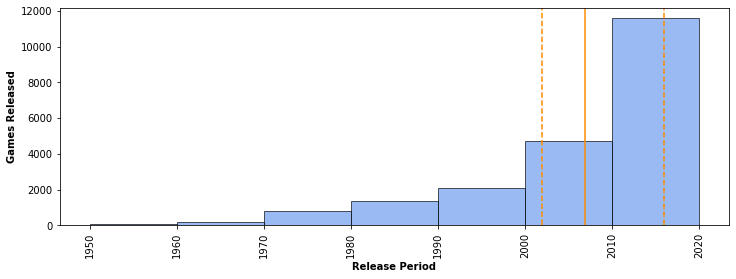

In [ ]:
plt.figure(figsize=(12,4))
plt.hist(game_df[(game_df['year']>=1950) & (game_df['year']<=2020)].year, color='cornflowerblue', edgecolor='k', alpha=0.65,bins=7)
plt.xticks(rotation=90)
plt.xlabel('Release Period',fontweight='bold')
plt.ylabel('Games Released',fontweight='bold')
plt.axvline(game_df[(game_df['year']>=1950) & (game_df['year']<=2020)].year.mean(),color='darkorange')
plt.axvline(game_df[(game_df['year']>=1950) & (game_df['year']<=2020)].year.quantile(q=0.25), linestyle='dashed',color='darkorange')
plt.axvline(game_df[(game_df['year']>=1950) & (game_df['year']<=2020)].year.quantile(q=0.75), linestyle='dashed',color='darkorange')
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.show()

In [ ]:
f1 = pd.DataFrame(data={'C':[0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
                        'Train':[0.111,0.25,0.464,0.731,0.942,0.993,0.997,0.995,0.991],
                        'Test':[0.112,0.244,0.432,0.589,0.609,0.552,0.53,0.527,0.525]})

In [ ]:
def feature_train(source,feats=None, targ=None, drop=None,scale=False):
  source = source[source['year'] >= 2000]
  one_hot = list(source.columns[33:])
  one_hot.append('cooperative')
  source[one_hot]=source[one_hot].fillna(0)

  feature_columns = ['num_votes','year','complexity','max_players','max_time','min_age','min_players', 'min_time', 'bayes_rating','cooperative','name','description','category','bgg_id','rank']
  
  func_cols = ['year','complexity','max_players','max_time','min_age','min_players', 'min_time','bayes_rating','num_votes']

  if drop:
    source = source.drop(columns=drop,axis=1)
    feature_columns = [x for x in feature_columns if x not in drop]
    func_cols = [x for x in func_cols if x not in drop]
  
  if feats:
    for feat in feats:
      ls = [col for col in source[one_hot] if col.startswith(feat)]
      feature_columns.extend(ls)

  
  features_df = source[feature_columns]
  
  def impute_func(df, dftype='x'):
    if dftype == 'x':
      for col in func_cols:
        if col in df.columns:
          med_imp=SimpleImputer(missing_values=np.nan,strategy='median')
          df[col]=med_imp.fit_transform(df[col].values.reshape(-1,1))[:,0]
        else:
          pass
      return df
    elif dftype == 'y':
      med_imp=SimpleImputer(missing_values=np.nan,strategy='median')
      df=med_imp.fit_transform(df.values.reshape(-1,1))[:,0]
      return df

  def scaler_func(df):
    scaler = preprocessing.MinMaxScaler()
    cols = [x for x in func_cols if x in df.columns]
    scaler.fit(df[cols])
    d_t = scaler.transform(df[cols]).T
    for idx, col in enumerate(cols):
      df[col] = d_t[idx]
    return df

  if targ:
    X = features_df.drop(columns=[targ], axis=1)
    y = features_df[targ]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
    
    X_train = impute_func(X_train)
    X_test = impute_func(X_test)
    y_train = impute_func(y_train,dftype='y')
    y_test = impute_func(y_test,dftype='y')

    if scale==True:
      X_train = scaler_func(X_train)
      X_test = scaler_func(X_test)

    return X_train, X_test, y_train, y_test
  else:
    X_train, X_val = train_test_split(features_df, test_size=0.2, random_state=RANDOM_STATE)
    
    X_train = impute_func(X_train)
    X_val = impute_func(X_val)
    
    return X_train, X_val


In [ ]:
SVDX_train, SVDX_test, SVDy_train, SVDy_test = feature_train(
    game_df,['mechanic_','game_type_','category_'], 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=True)

X_train, X_test, y_train, y_test = feature_train(
    game_df,['mechanic_','game_type_','category_'], 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=False)

doc_train, doc_val = feature_train(game_df,['mechanic_','game_type_','category_'])

print(f'original shape: {len(game_df)}')
print(f'train size: {len(X_train)}, test size: {len(X_test)}')

original shape: 22192
train size: 12966, test size: 4323


## Data prep

In [ ]:
# game counts by the decade
year_counts=pd.DataFrame(game_df.year.value_counts())
decade_counts=pd.DataFrame(year_counts.groupby((year_counts.index//10)*10).sum())
decade_counts.reset_index(inplace=True)
decade_counts.columns=['year','game_count']
decade_counts.sort_values(by='game_count',ascending=False).head(10)

year  game_count
1  2010       10643
0  2000        4712
2  2020        1934

### Data Imputation

In [ ]:
#imputation now included in train split func


# core features + designers and artists
target_cols=['year','complexity','max_players','max_time','min_age','min_players', 'min_time']

gt=[col for col in game_df[one_hot] if col.startswith('game_type_')]
#mec=[col for col in game_df[one_hot] if col.startswith('mechanic_')]
cat=[col for col in game_df[one_hot] if col.startswith('category_')]
#fam=[col for col in game_df[one_hot] if col.startswith('family_')]
target_cols.extend(gt)
#target_cols.extend(mec)
target_cols.extend(cat)
#target_cols.extend(fam)
target_cols.append('cooperative')
# game_df[target_cols].isna().sum() nan count from the core features

#just usiing simple imputer to take care of the nans
for col in target_cols[1:]:
  med_imp=SimpleImputer(missing_values=np.nan,strategy='median')
  X_train[col]=med_imp.fit_transform(X_train[col].values.reshape(-1,1))[:,0]
  #valid_df[col]=med_imp.transform(valid_df[col].values.reshape(-1,1))[:,0]
  X_test[col]=med_imp.transform(X_test[col].values.reshape(-1,1))[:,0]

#### Unsupervised imputation testing

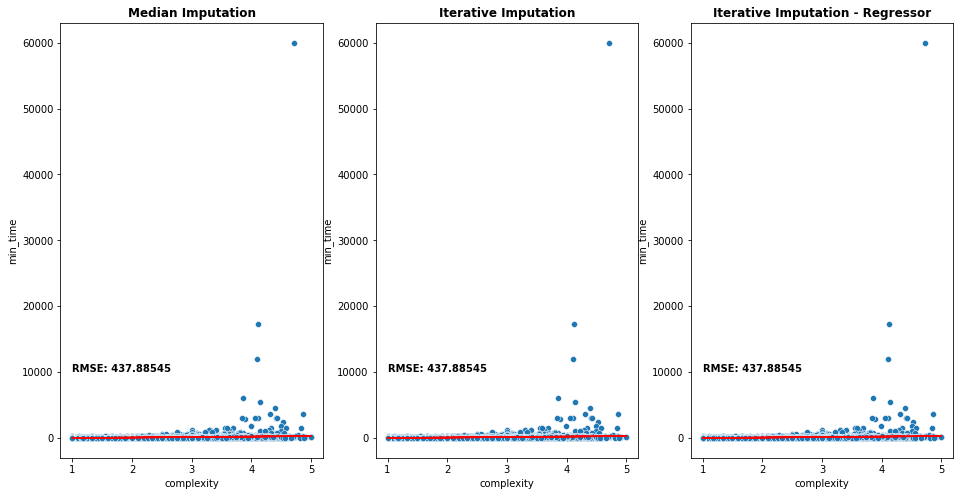

In [ ]:
# unsupervised imputation.
target_cols=['year','complexity','max_players','max_time','min_age','min_players', 'min_time']
# median imp
median_imputer = SimpleImputer(strategy='median')
median_imputed = median_imputer.fit_transform(game_df[target_cols])
game_df_median_imputed = pd.DataFrame(median_imputed, columns=target_cols)

# Iterative imp - no regressor
iter_imputer = IterativeImputer(random_state=RANDOM_STATE)
iter_imputed = iter_imputer.fit_transform(game_df[target_cols])
game_df_iter_imputed = pd.DataFrame(iter_imputed, columns=target_cols)

# # Iterative imp - regressor
iter_imputer = IterativeImputer(random_state=RANDOM_STATE,estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),add_indicator=True)
iter_reg_imputed = iter_imputer.fit_transform(game_df[target_cols])
game_df_iter_reg_imputed=pd.DataFrame(iter_reg_imputed).iloc[:,:7]
game_df_iter_reg_imputed.columns=target_cols

# visualizing the different imputation methods
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(16, 8))
axes = np.reshape(axes, -1)
game_dfs = [game_df_median_imputed, game_df_iter_imputed,game_df_iter_reg_imputed]
titles = ['Median Imputation', 'Iterative Imputation','Iterative Imputation - Regressor']

for i, game_df in enumerate(game_dfs):
    # Plotting the data
    sns.scatterplot(data=game_df,x='complexity', y='min_time',ax=axes[i]).set_title(titles[i])

    x=game_df.complexity
    y=game_df.min_time
    a, b = np.polyfit(x, y, 1)
    lin_reg = a*x + b
    axes[i].plot(x, lin_reg, color='red')
    
    # Setting the titles
    axes[i].set_title(titles[i], fontsize=12, fontweight='bold')
    rmse = round(mean_squared_error(y, lin_reg, squared=False), 5)
    axes[i].text(1, 10000, f'RMSE: {rmse}', fontsize=10, fontweight='bold')

In [ ]:
#scaling included in train split func

cols=['year','complexity','max_players','max_time','min_age','min_players', 'min_time']
scale_df = game_df[target_cols]
scaler = preprocessing.MinMaxScaler()
scaler.fit(game_df[target_cols])
d_t = scaler.transform(game_df[target_cols]).T
for idx, col in enumerate(cols):
  scale_df[col] = d_t[idx]


scale_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


year  complexity  max_players  max_time   min_age  min_players  \
4993   0.130435    0.336275     0.004008  0.003956  0.375000     0.222222   
79795  0.782609    0.000000     0.005010  0.002622  0.375000     0.222222   
21737  0.043478    0.050000     0.007014  0.000844  0.291667     0.333333   
92974  0.913043    0.312500     0.003006  0.002622       NaN     0.111111   
1111   0.043478    0.250000     0.003006  0.001956  0.291667     0.111111   
...         ...         ...          ...       ...       ...          ...   
605    0.000000    0.079775     0.005010  0.001956  0.375000     0.222222   
76747  0.739130    0.291675     0.004008  0.001956  0.375000     0.222222   
57247  0.565217    0.208325     0.004008  0.001733  0.291667     0.111111   
46225  0.478261    0.107150     0.003006  0.001289  0.375000     0.111111   
89033  0.826087    0.000000     0.003006  0.000844  0.291667     0.111111   

       min_time  
4993   0.005151  
79795  0.002257  
21737  0.001100  
92974  0.001389  
1111   0.002546  
...         ...  
605    0.002546  
76747  0.001678  
57247  0.001100  
46225  0.001678  
89033  0.001100  

[12603 rows x 7 columns]

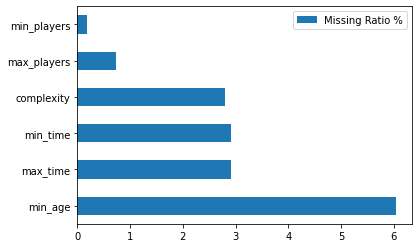

In [ ]:
#plot code from Vojtech Stas on SO
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(game_df[target_cols])

## Dimensionality Reduction

### sklearn dimensionality reductions

In [ ]:
scale_df = scale_df.drop('year', axis=1)

In [ ]:
len(scale_df)

12603

In [ ]:
X.shape

(17289, 33211)

In [ ]:
# finding the one-hot encoded items for PCA
pca_candidates=game_df.columns[33:]
# seperating out columns for PCA
y=game_df['bayes_rating']
X=game_df[pca_candidates]
X.fillna(0,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
n_components=3500
svd=TruncatedSVD(n_components=n_components,n_iter=8,random_state=RANDOM_STATE)
sv_names=['SV'+str(i) for i in range(1,n_components+1)]
svd.fit(X)
svd_X=svd.transform(X)
svd_df=pd.DataFrame(svd_X,columns=sv_names)

In [ ]:
# svd_df.to_csv('dimension_reduced_df.csv',index=False)
svd_df.to_parquet('dimension_reduced_df.parquet',engine='fastparquet')

In [ ]:
pca=PCA(n_components=3500,random_state=RANDOM_STATE)
pca.fit(X)
pca_X=pca.transform(X)

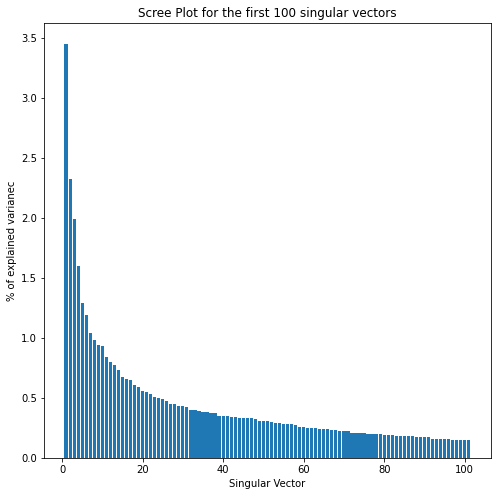

In [ ]:
variance=np.round(pca.explained_variance_ratio_*100,decimals=2)
variance=variance[:101]
sv_names=['PC'+str(i) for i in range(1,101)]
plt.figure(figsize=(8,8))
plt.bar(x=range(1,102),height=variance)
plt.ylabel('% of explained varianec')
plt.xlabel('Singular Vector')
plt.title('Scree Plot for the first 100 singular vectors')
plt.show()

In [ ]:
pca_500=PCA(n_components=500, random_state=RANDOM_STATE)
pca_500.fit(X)
pca_X=pca_500.transform(X)

In [ ]:
# testing 500 PCA - Nick was here (using all of Kuan's code)
pca_90=PCA(n_components=0.9, random_state=RANDOM_STATE)
pca_90.fit(scale_df)
pca_X=pca_90.transform(scale_df)

In [ ]:
plt.plot(np.cumsum(pca_90.explained_variance_ratio_*100))
plt.xlabel('component order')
plt.ylabel('explained variance')
print(f'number of components: {pca_90.n_components_}')
print(f'total 100 components variance explained: {np.cumsum(pca_90.explained_variance_ratio_*100)[-1]}')

In [ ]:
pca_2000=PCA(n_components=50, random_state=RANDOM_STATE)
pca_2000.fit(scale_df)
pca_X2=pca_2000.transform(scale_df)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(np.cumsum(pca_1000.explained_variance_ratio_*100))
ax1.set_title("500 Components")

ax2.plot(np.cumsum(pca_2000.explained_variance_ratio_*100))
ax2.set_title("1000 Components")


print(f'1st 500 component variance explained: {np.cumsum(pca_1000.explained_variance_ratio_*100)[0]}')
print(f'total components variance explained: {np.cumsum(pca_1000.explained_variance_ratio_*100)[-1]}')

print(f'1st 1000 component variance explained: {np.cumsum(pca_2000.explained_variance_ratio_*100)[0]}')
print(f'total components variance explained: {np.cumsum(pca_2000.explained_variance_ratio_*100)[-1]}')

In [ ]:
components=[500,1000,1500,2000,2500,3000,3500]

for comp in components:
  pca=PCA(n_components=comp,random_state=RANDOM_STATE)
  pca.fit(X)
  print(f'PCA number of components: {comp}, total explained variance: {np.cumsum(pca.explained_variance_ratio_*100)[-1]}')

PCA number of components: 500, total explained variance: 67.46955440300039
PCA number of components: 1000, total explained variance: 76.11116412031566
PCA number of components: 1500, total explained variance: 80.95738807158772
PCA number of components: 2000, total explained variance: 84.16135999040995
PCA number of components: 2500, total explained variance: 86.66036914398221
PCA number of components: 3000, total explained variance: 88.64214654122534
PCA number of components: 3500, total explained variance: 90.268731966155


In [ ]:
for comp in components:
  svd=TruncatedSVD(n_components=comp,n_iter=8,random_state=RANDOM_STATE)
  svd.fit(X)
  print(f'SVD number of components: {comp}, total variance explained: {np.cumsum(svd.explained_variance_ratio_)[-1]}')

SVD number of components: 500, total variance explained: 0.6748242957870598
SVD number of components: 1000, total variance explained: 0.761251436868282
SVD number of components: 1500, total variance explained: 0.8097183131621184
SVD number of components: 2000, total variance explained: 0.8430260226686025
SVD number of components: 2500, total variance explained: 0.8679279959362809
SVD number of components: 3000, total variance explained: 0.8876725904375876
SVD number of components: 3500, total variance explained: 0.9038724182445931


number of components: 500
total 100 components variance explained: 67.99750631266166


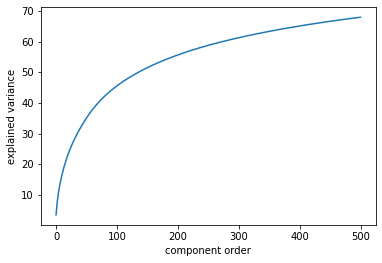

In [ ]:
pca_500=PCA(n_components=500, random_state=RANDOM_STATE)
pca_500.fit(X)
pca_X=pca_500.transform(X)
plt.plot(np.cumsum(pca_500.explained_variance_ratio_*100))
plt.xlabel('component order')
plt.ylabel('explained variance')
print(f'number of components: {pca_500.n_components_}')
print(f'total 100 components variance explained: {np.cumsum(pca_500.explained_variance_ratio_*100)[-1]}')

number of components: 1000
total 100 components variance explained: 76.80602366293228


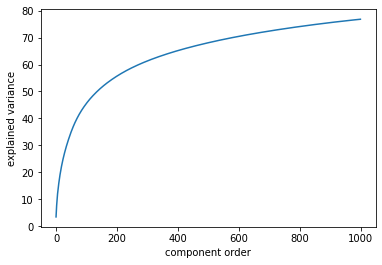

In [ ]:
pca_1000=PCA(n_components=1000, random_state=RANDOM_STATE)
pca_1000.fit(X)
pca_X=pca_1000.transform(X)
plt.plot(np.cumsum(pca_1000.explained_variance_ratio_*100))
plt.xlabel('component order')
plt.ylabel('explained variance')
print(f'number of components: {pca_1000.n_components_}')
print(f'total 100 components variance explained: {np.cumsum(pca_1000.explained_variance_ratio_*100)[-1]}')

number of components: 2000
total 100 components variance explained: 85.04366218171602


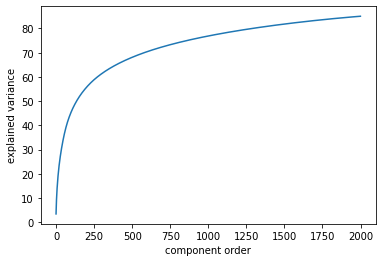

In [ ]:
pca_2000=PCA(n_components=2000, random_state=RANDOM_STATE)
pca_2000.fit(X)
pca_X=pca_2000.transform(X)
plt.plot(np.cumsum(pca_2000.explained_variance_ratio_*100))
plt.xlabel('component order')
plt.ylabel('explained variance')
print(f'number of components: {pca_2000.n_components_}')
print(f'total 100 components variance explained: {np.cumsum(pca_2000.explained_variance_ratio_*100)[-1]}')

total 550 components variance explained: 0.7485957628253822


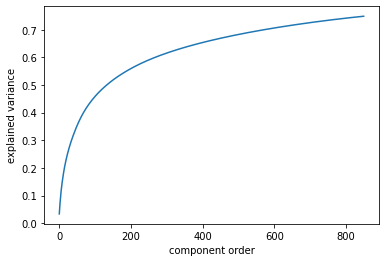

In [ ]:
# sklearn SVD approach
svd=TruncatedSVD(n_components=850,n_iter=5,random_state=RANDOM_STATE)
svd.fit(X)
svd_variance=(sorted(svd.explained_variance_ratio_,reverse=True))
display(plt.plot(np.cumsum(svd_variance)))
plt.xlabel('component order')
plt.ylabel('explained variance')
print(f'total 550 components variance explained: {np.cumsum(svd_variance)[-1]}')

total 550 components variance explained: 0.7673467393959892


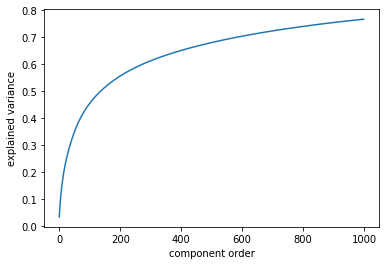

In [ ]:
# sklearn SVD approach
svd=TruncatedSVD(n_components=1000,n_iter=5,random_state=RANDOM_STATE)
svd.fit(X)
svd_variance=(sorted(svd.explained_variance_ratio_,reverse=True))
display(plt.plot(np.cumsum(svd_variance)))
plt.xlabel('component order')
plt.ylabel('explained variance')
print(f'total 550 components variance explained: {np.cumsum(svd_variance)[-1]}')

total 550 components variance explained: 0.8519835209729907


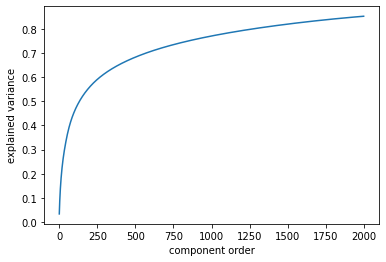

In [ ]:
# sklearn SVD approach
svd=TruncatedSVD(n_components=2000,n_iter=5,random_state=RANDOM_STATE)
svd.fit(X)
svd_variance=(sorted(svd.explained_variance_ratio_,reverse=True))
display(plt.plot(np.cumsum(svd_variance)))
plt.xlabel('component order')
plt.ylabel('explained variance')
print(f'total 550 components variance explained: {np.cumsum(svd_variance)[-1]}')

In [ ]:
# sklearn SVD approach
svd=TruncatedSVD(n_components=2500,n_iter=5,random_state=RANDOM_STATE)
svd.fit(X)
svd_variance=(sorted(svd.explained_variance_ratio_,reverse=True))
display(plt.plot(np.cumsum(svd_variance)))
plt.xlabel('component order')
plt.ylabel('explained variance')
print(f'total 550 components variance explained: {np.cumsum(svd_variance)[-1]}')

### Prince dimensionality reduction tests

In [ ]:
from prince import PCA
ppca=PCA(n_components=2000,n_iter=3,random_state=RANDOM_STATE)
ppca.fit(X)
# display(plt.plot(np.cumsum(ppca.explained_inertia_*100)))
print(f'total 2000 components variance explained: {round(np.cumsum(ppca.explained_inertia_*100)[-1],2)}%')
# features_ppca=ppca.transform(scale_df)
# features_ppca.head()
# ppca.column_correlations(game_df[scale_df.columns])

total 2000 components variance explained: 41.09%


In [ ]:
# testing out correspondence analysis from prince
from prince import CA
# CRASHING HERE
corr_analysis=CA(n_components=10,n_iter=4,random_state=RANDOM_STATE)
corr_analysis.fit(categorical)
corr_analysis.column_coordinates(categorical)

In [ ]:
# making groups for multifactor analysis
import collections
import re
groups = collections.defaultdict(list)
test=np.array(one_hot)
for i in test:
  match=re.search(r'(\w+_)(.*)',i)
  try:
    groups[match.group(1)].append(match.group(2))
  except:
    continue

In [ ]:
# multifactor analysis
from prince import MFA
mfa = MFA(groups=groups,n_components=10,n_iter=2,random_state=RANDOM_STATE)
# CRASHING HERE
mfa.fit(categorical)
mfa.transform(categorical)
mfa.plot_row_coordinates(X=categorical,labels=categorical.name)

In [ ]:
# FAMD 
from prince import FAMD
famd=FAMD(n_components=10,n_iter=2,random_state=RANDOM_STATE)
# CRASHES here
famd.fit(categorical[:-1]) # learning the data without the label
famd.transform(categorical[:-1]) #learning the data without the label

## Topic Modeling

### Text Preprocessing

In [ ]:
X_train

complexity  max_players  max_time  min_age  min_players  min_time  \
15058      2.8889         10.0     240.0     12.0          2.0     240.0   
87295      3.7974          5.0     150.0     14.0          2.0      90.0   
19027      1.0455          8.0      10.0      8.0          2.0      10.0   
77167      1.5000          6.0      30.0     12.0          2.0      30.0   
25707      2.2317          2.0      40.0     12.0          2.0      40.0   
...           ...          ...       ...      ...          ...       ...   
50047      2.8462          2.0     150.0     12.0          2.0     150.0   
81968      2.6000          2.0     480.0     16.0          1.0     120.0   
38918      1.0000          8.0      35.0     12.0          3.0      35.0   
94943      1.8421          4.0      30.0      7.0          1.0      20.0   
9516       1.0000          5.0      60.0     14.0          2.0      60.0   

       cooperative  mechanic_Acting  mechanic_Action Drafting  \
15058          0.0              0.0                       0.0   
87295          0.0              0.0                       0.0   
19027          0.0              0.0                       0.0   
77167          0.0              0.0                       0.0   
25707          0.0              0.0                       0.0   
...            ...              ...                       ...   
50047          0.0              0.0                       0.0   
81968          0.0              0.0                       0.0   
38918          0.0              0.0                       0.0   
94943          0.0              0.0                       0.0   
9516           0.0              0.0                       0.0   

       mechanic_Action Points  ...  category_Transportation  category_Travel  \
15058                     1.0  ...                      0.0              0.0   
87295                     0.0  ...                      0.0              0.0   
19027                     0.0  ...                      0.0              0.0   
77167                     0.0  ...                      0.0              0.0   
25707                     0.0  ...                      0.0              0.0   
...                       ...  ...                      ...              ...   
50047                     0.0  ...                      0.0              0.0   
81968                     0.0  ...                      0.0              0.0   
38918                     0.0  ...                      0.0              0.0   
94943                     0.0  ...                      0.0              0.0   
9516                      0.0  ...                      0.0              0.0   

       category_Trivia  category_Video Game Theme  category_Vietnam War  \
15058              0.0                        0.0                   0.0   
87295              0.0                        0.0                   0.0   
19027              0.0                        0.0                   0.0   
77167              0.0                        0.0                   0.0   
25707              0.0                        0.0                   0.0   
...                ...                        ...                   ...   
50047              0.0                        0.0                   0.0   
81968              0.0                        0.0                   0.0   
38918              0.0                        0.0                   0.0   
94943              0.0                        0.0                   0.0   
9516               1.0                        0.0                   0.0   

       category_Wargame  category_Word Game  category_World War I  \
15058               1.0                 0.0                   0.0   
87295               0.0                 0.0                   0.0   
19027               0.0                 0.0                   0.0   
77167               0.0                 0.0                   0.0   
25707               0.0                 0.0                   0.0   
...                 ...              

In [ ]:
#refactored spacy implementation - using the split train_df
# descriptions=train_df[~train_df['description'].isna()][['name','description','category']]
#descriptions=X_train[['name','description','category']]

def doc_text_preprocessing(ser):
  nlp=spacy.load("en_core_web_sm", exclude=['parser','ner','textcat'])

  """text processing steps"""
  import re
  stop_words=set(stopwords.words('english'))
  stop_words.update(['game','player','players','games', 'also', 
                     'description','publisher'] + list(set(stopwords.words('spanish'))))
  
  single_letter_replace=lambda c: re.sub("\s+\w{1}\s+|\n|-|—",'',c)
  to_lower_func=lambda c: c.lower()

  lemma_text=[preprocess_string(
      ' '.join([token.lemma_ for token in desc]
          ),[remove_stopwords,strip_numeric,strip_punctuation,strip_tags,
             strip_multiple_whitespaces,single_letter_replace,to_lower_func]
             ) for desc in ser.apply(lambda x: nlp(x))]

  tokenize_text=[[word for word in string if word not in stop_words] for string in lemma_text]

  return tokenize_text

In [ ]:
descriptions['description']=descriptions['description'].fillna('no words')
descriptions['cleaned_descriptions']=doc_text_preprocessing(descriptions['description'])
descriptions['cleaned_word_count']=descriptions['cleaned_descriptions'].map(len)
display(descriptions.sort_values(by='cleaned_word_count',ascending=False).head())
print(f'total unique word: {len(set().union(*descriptions.cleaned_descriptions.tolist()))}, checking df size: {descriptions.shape}')

name  \
87686  Robinson Crusoe: Escape from Despair Island   
33846                     Nothing Gained But Glory   
57517        Enemy Coast Ahead: The Dambuster Raid   
42066                              Next War: Korea   
61761                       At Any Cost: Metz 1870   

                                             description  \
87686  “Never any young adventurer's misfortunes, I b...   
33846  Nothing Gained But Glory will be the fifth vol...   
57517  Information from publishers game page\n\nOpera...   
42066  Sixty years of tense, uneasy peace are shatter...   
61761  At Any Cost: Metz 1870 is a game simulating th...   

                                                category  \
87686  ['Adventure', 'Card Game', 'Novel-based', 'Pir...   
33846                       ['Pike and Shot', 'Wargame']   
57517   ['Aviation / Flight', 'Wargame', 'World War II']   
42066                      ['Modern Warfare', 'Wargame']   
61761                     ['Post-Napoleonic', 'Wargame']   

                                    cleaned_descriptions  cleaned_word_count  
87686  [young, adventurermisfortunebelieve, begin, so...                1172  
33846  [gained, glory, fifth, volume, award, win, mus...                 873  
57517  [information, page, operation, chastise, dambu...                 865  
42066  [year, tense, uneasy, peace, shatter, korean, ...                 785  
61761  [cost, metz, simulate, situation, west, metz, ...                 737

total unique word: 58337, checking df size: (12966, 5)


In [ ]:
descriptions = doc_train[~doc_train['description'].isna()][['name','description','category']]
descriptions['cleaned_descriptions']=doc_text_preprocessing(descriptions['description'])

In [ ]:
descriptions['cleaned_descriptions']

32434    [designer, making, president, goal, father, re...
10747    [publisherwebsite, fall, republic, hand, senat...
88932    [exceed, fighting, system, dig, brand, new, fi...
36143    [tobago, adventure, possess, different, treasu...
4693     [compete, collect, card, quick, blurt, correct...
                               ...                        
50047    [volume, viii, introduce, new, feature, core, ...
81968    [pacific, tide, united, states, versus, japan,...
38918    [truth, tell, reveal, new, laugh, loud, preten...
94943    [codex, naturalis, continue, work, illuminate,...
9516     [race, pawn, pentagon, shape, board, correctly...
Name: cleaned_descriptions, Length: 13830, dtype: object

In [ ]:
# all_words=set().union(*descriptions.cleaned_descriptions.tolist())
# all_words=list(all_words)
# !pip install langdetect
from langdetect import detect
import plotly.express as px
detected_lang=[]
for word in descriptions.cleaned_descriptions:
  word=', '.join(word)
  detected_lang.append(detect(word))
c=Counter(detected_lang)
df_lang=pd.DataFrame([(i, c[i] / len(detected_lang) * 100.0) for i in c],columns=['Detected_language','Percentage'])
fig=px.pie(df_lang,values='Percentage',names='Detected_language',color_discrete_sequence=px.colors.sequential.Turbo)
fig.update_layout(
    font_family="Times New Roman",
    font_size=10
)
fig.update_traces(textposition='inside', textinfo='percent+label')

In [ ]:
fig=px.pie(df_lang,values='Percentage',names='Detected_language',color_discrete_sequence=px.colors.sequential.RdBu_r)
fig.update_layout(
    font_family="Times New Roman",
    font_size=10
)
fig.update_traces(textposition='inside', textinfo='percent+label')

In [ ]:
dir(px.colors.sequential)

['Aggrnyl',
 'Aggrnyl_r',
 'Agsunset',
 'Agsunset_r',
 'Blackbody',
 'Blackbody_r',
 'Bluered',
 'Bluered_r',
 'Blues',
 'Blues_r',
 'Blugrn',
 'Blugrn_r',
 'Bluyl',
 'Bluyl_r',
 'Brwnyl',
 'Brwnyl_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'Burg',
 'Burg_r',
 'Burgyl',
 'Burgyl_r',
 'Cividis',
 'Cividis_r',
 'Darkmint',
 'Darkmint_r',
 'Electric',
 'Electric_r',
 'Emrld',
 'Emrld_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'Hot',
 'Hot_r',
 'Inferno',
 'Inferno_r',
 'Jet',
 'Jet_r',
 'Magenta',
 'Magenta_r',
 'Magma',
 'Magma_r',
 'Mint',
 'Mint_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'Oryel',
 'Oryel_r',
 'Peach',
 'Peach_r',
 'Pinkyl',
 'Pinkyl_r',
 'Plasma',
 'Plasma_r',
 'Plotly3',
 'Plotly3_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuRd',
 'PuRd_r',
 'Purp',
 'Purp_r',
 'Purples',
 'Purples_r',
 'Purpor',
 'Purpor_r',
 'Rainbow',
 'Rainbow_r',
 'RdBu',
 'RdBu_r',
 'RdPu',
 'RdPu_r',
 'Redor',
 'Redor_r',
 'Reds',
 'Reds_r',
 'Sunset

In [ ]:
# word distributions
from collections import Counter
import plotly.express as px
seq=descriptions.cleaned_descriptions.tolist()
counter=Counter(x for xs in seq for x in set(xs))
word_counts=pd.DataFrame.from_dict(counter,orient='index').reset_index()
word_counts.columns=['word','word_counts']
top_30_words=word_counts.sort_values(by='word_counts',ascending=False)[:30]
fig = px.bar(top_30_words,x='word',y='word_counts',
             labels={'word':'Word','word_counts':'Total Word Count'},
             color='word_counts',color_continuous_scale=px.colors.sequential.RdBu)
fig.update_layout(
    font_family="Times New Roman",
    font_size=10,
    showlegend=False
)
# top_30_words

### Topic Modeling - NMF

In [ ]:
# # finding optimial number of topics with updated preprocessed text
texts=descriptions['cleaned_descriptions']
dictionary=corpora.Dictionary(descriptions['cleaned_descriptions'])
dictionary.filter_extremes(no_below=10,no_above=0.9,keep_n=10000)
doc_term_mat=[dictionary.doc2bow(text) for text in descriptions['cleaned_descriptions']]
num_topics=list(np.arange(1,56,5))
coherence=list()


for n in num_topics:
  nmf=Nmf(corpus=doc_term_mat,num_topics=n,id2word=dictionary,chunksize=1000,passes=6,kappa=0.1,
          minimum_probability=0.01,w_max_iter=300,w_stop_condition=0.0001,h_max_iter=100,h_stop_condition=0.001,eval_every=10,
          normalize=True,random_state=RANDOM_STATE)
  coherence_model=CoherenceModel(model=nmf,texts=texts,dictionary=dictionary,coherence='c_v')
  coherence.append(coherence_model.get_coherence())

In [ ]:
# num_topics=list(np.arange(1,56,5))
coherence=np.array(coherence)
coherence_norm=coherence*100
coherence_dict=dict(zip(num_topics,coherence_norm))
best_num_topics=sorted(coherence_dict.items(), key=lambda item: -item[1])[0][0]
best_coherence_score=sorted(coherence_dict.items(), key=lambda item: -item[1])[0][1]
coherence_scores=pd.DataFrame.from_dict(coherence_dict,orient='index').reset_index()
coherence_scores.columns=['num_topics','coherence_score']
import plotly.express as px
coherence_scores
px.line(coherence_scores,x='num_topics',y='coherence_score',title=f'Coherence Score vs Number of Topics <br> Num of Topics with highest score: {best_num_topics}, score: {round(best_coherence_score,2)}')

In [ ]:
num_topics=list(np.arange(1,56,5))
coherence=np.array(coherence)
coherence_norm=coherence*100
coherence_dict=dict(zip(num_topics,coherence_norm))
best_num_topics=sorted(coherence_dict.items(), key=lambda item: -item[1])[0][0]
best_coherence_score=sorted(coherence_dict.items(), key=lambda item: -item[1])[0][1]
coherence_scores=pd.DataFrame.from_dict(coherence_dict,orient='index').reset_index()
coherence_scores.columns=['num_topics','coherence_score']
import plotly.express as px
coherence_scores
px.line(coherence_scores,x='num_topics',y='coherence_score',title=f'Coherence Score vs Number of Topics - X_train only<br> Num of Topics with highest score: {best_num_topics}, score: {round(best_coherence_score,2)}')

In [ ]:
# using the top num of topics for the nmf
descriptions['description']=descriptions['description'].fillna('no words')
descriptions['cleaned_descriptions']=doc_text_preprocessing(descriptions['description'])
best_num_topics=16
vectorizer=TfidfVectorizer(max_features = 10000, ngram_range = (1,2), min_df=10, max_df=0.9,preprocessor=' '.join)
tfidf=vectorizer.fit_transform(descriptions.cleaned_descriptions)
tfidf_features = vectorizer.get_feature_names_out()
nmf=NMF(n_components=best_num_topics,init='nndsvd',random_state=RANDOM_STATE).fit(tfidf)

In [ ]:
import pickle
pickle.dump(nmf,open('nmf_trained.pkl','wb'))

In [ ]:
!ls

drive  nmf_trained.pkl	sample_data


In [ ]:
W=nmf.transform(tfidf)
pd.DataFrame(W)

def topic_table(n_top_words, feature_names, nmf):
  topics = {}
  for i, topic_vec in enumerate(nmf.components_):
    topic_descr = ''
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      topic_descr = topic_descr + feature_names[fid] + " "
    topics[i] = topic_descr.split()
  return topics
# Label topics with top 5 terms
topic_table=topic_table(10, tfidf_features, nmf)
descriptions['Topic']=W.argmax(axis=1)
descriptions['Topic_top_10_words']=descriptions['Topic'].map(topic_table)
descriptions

name  \
15058                                            Gutshot   
87295                                     Crystal Palace   
19027                                         Crazy Kick   
77167                                       Gold Raiders   
25707                           Okko: Era of the Asagiri   
...                                                  ...   
50047                                            Newtown   
81968  Pacific Tide: The United States Versus Japan, ...   
38918                                      Truth Be Told   
94943                                    Codex Naturalis   
9516                                      Don't Quote Me   

                                             description  \
15058  WINNER -- 2006 Origins Award for "Historical M...   
87295  In Crystal Palace, players take on the role of...   
19027  2006 is the year of the football world champio...   
77167  In Gold Raiders, your expedition begins as you...   
25707  Okko is a miniature game that is played on a b...   
...                                                  ...   
50047  Volume VIII introduces several new features to...   
81968  Pacific Tide: The United States versus Japan, ...   
38918  Truth Be Told is the revealing new laugh-out-l...   
94943  In CODEX Naturalis, you must continue the work...   
9516   Players race their pawns around a pentagon sha...   

                                                category  \
15058  ['American West', 'Fighting', 'Miniatures', 'W...   
87295                               ['Dice', 'Economic']   
19027               ['Card Game', 'Real-time', 'Sports']   
77167                                               None   
25707  ['Comic Book / Strip', 'Fantasy', 'Fighting', ...   
...                                                  ...   
50047          ['American Revolutionary War', 'Wargame']   
81968            ['Nautical', 'Wargame', 'World War II']   
38918                                     ['Party Game']   
94943                     ['Card Game', 'Environmental']   
9516                            ['Party Game', 'Trivia']   

                                    cleaned_descriptions  Topic  \
15058  [winner, origins, award, historical, miniature...     12   
87295  [crystal, palace, role, nation, time, world, f...      4   
19027  [year, football, world, championship, ligretto...     12   
77167  [gold, raiders, expedition, begin, plane, spla...      9   
25707  [okko, miniature, play, board, square, simulat...     15   
...                                                  ...    ...   
50047  [volume, viii, introduce, new, feature, core, ...      3   
81968  [pacific, tide, united, states, versus, japan,...      3   
38918  [truth, tell, reveal, new, laugh, loud, preten...      5   
94943  [codex, naturalis, continue, work, illuminate,...      0   
9516   [race, pawn, pentagon, shape, board, correctly...      5   

                                      Topic_top_10_words  
15058  [team, time, play, escape, zombie, try, room, ...  
87295  [dice, roll, roll, dice, die, dice, roll, numb...  
19027  [team, time, play, escape, zombie, try, room, ...  
77167  [treasure, pirate, dragon, island, gold, chest...  
25707  [character, ability, character, card, action, ...  
...                                                  ...  
50047  [war, unit, battle, army, map, scenario, campa...  
81968  [war, unit, battle, army, map, scenario, campa...  
38918  [answer, question, category, answer, question,...  
94943  [card, play, hand, deck, play, card, draw, car...  
9516   [answer, question, category, answer, question,...  

[12966 rows x 6 columns]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
topic_num=descriptions.Topic.unique()
descriptions['Topic_top_10_words_str']=[','.join(map(str,l)) for l in descriptions.Topic_top_10_words]
descriptions['Topic_top_10_words_str'].unique()

array(['team,time,play,escape,zombie,try,room,clue,puzzle,story',
       'dice,roll,roll,dice,die,dice,roll,number,turn,roll,use,turn,set',
       'treasure,pirate,dragon,island,gold,chest,captain,collect,loot,adventure',
       'character,ability,character,card,action,token,funkoverse,unique,adventure,ability,token,special',
       'card,play,hand,deck,play,card,draw,card,play,card,hand,turn,discard',
       'hero,power,battle,deck,world,enemy,new,attack,control,powerful',
       'ship,pirate,space,crew,planet,fleet,captain,mission,alien,star',
       'city,build,building,resource,action,worker,new,money,good,phase',
       'war,unit,battle,army,map,scenario,campaign,force,rule,counter',
       'point,score,round,score,point,end,trick,number,point,win,win,scoring',
       'piece,board,color,place,space,square,piece,board,stack,place,piece,block',
       'word,letter,guess,clue,team,guess,word,use,letter,word,word,card,letter,card',
       'tile,place,place,tile,board,tile,place,tile,t

In [ ]:
top_words=10
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(125, 100), sharex=True)
    fig.tight_layout(pad=0.1)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words -1: -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 75})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=100)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=200)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(nmf,tfidf_features,top_words,'NMF generated topics')

In [ ]:
top_words=10
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 4, figsize=(125, 100), sharex=True)
    fig.tight_layout(pad=0.1)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words -1: -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 75})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=150)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=200)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(nmf,tfidf_features,top_words,'NMF generated topics - train_df only')

### Topic Modeling - LDA

In [ ]:
texts=descriptions['cleaned_descriptions']
dictionary=corpora.Dictionary(descriptions['cleaned_descriptions'])
dictionary.filter_extremes(no_below=10,no_above=0.9,keep_n=10000)
doc_term_mat=[dictionary.doc2bow(text) for text in descriptions['cleaned_descriptions']]

In [ ]:
lda = LdaModel
lda_model = lda(doc_term_mat,num_topics=6,id2word=dictionary,passes=50,minimum_probability=0.01,random_state=RANDOM_STATE,chunksize=1000)

In [ ]:
top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t+1, ) + x for x in lda_model.show_topic(t, topn = 10)])

lda_topics_df=pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])
lda_topics_df.head()

Topic   Word         P
0      1   card  0.150119
1      1   play  0.036824
2      1  point  0.029147
3      1   game  0.028262
4      1  round  0.023808

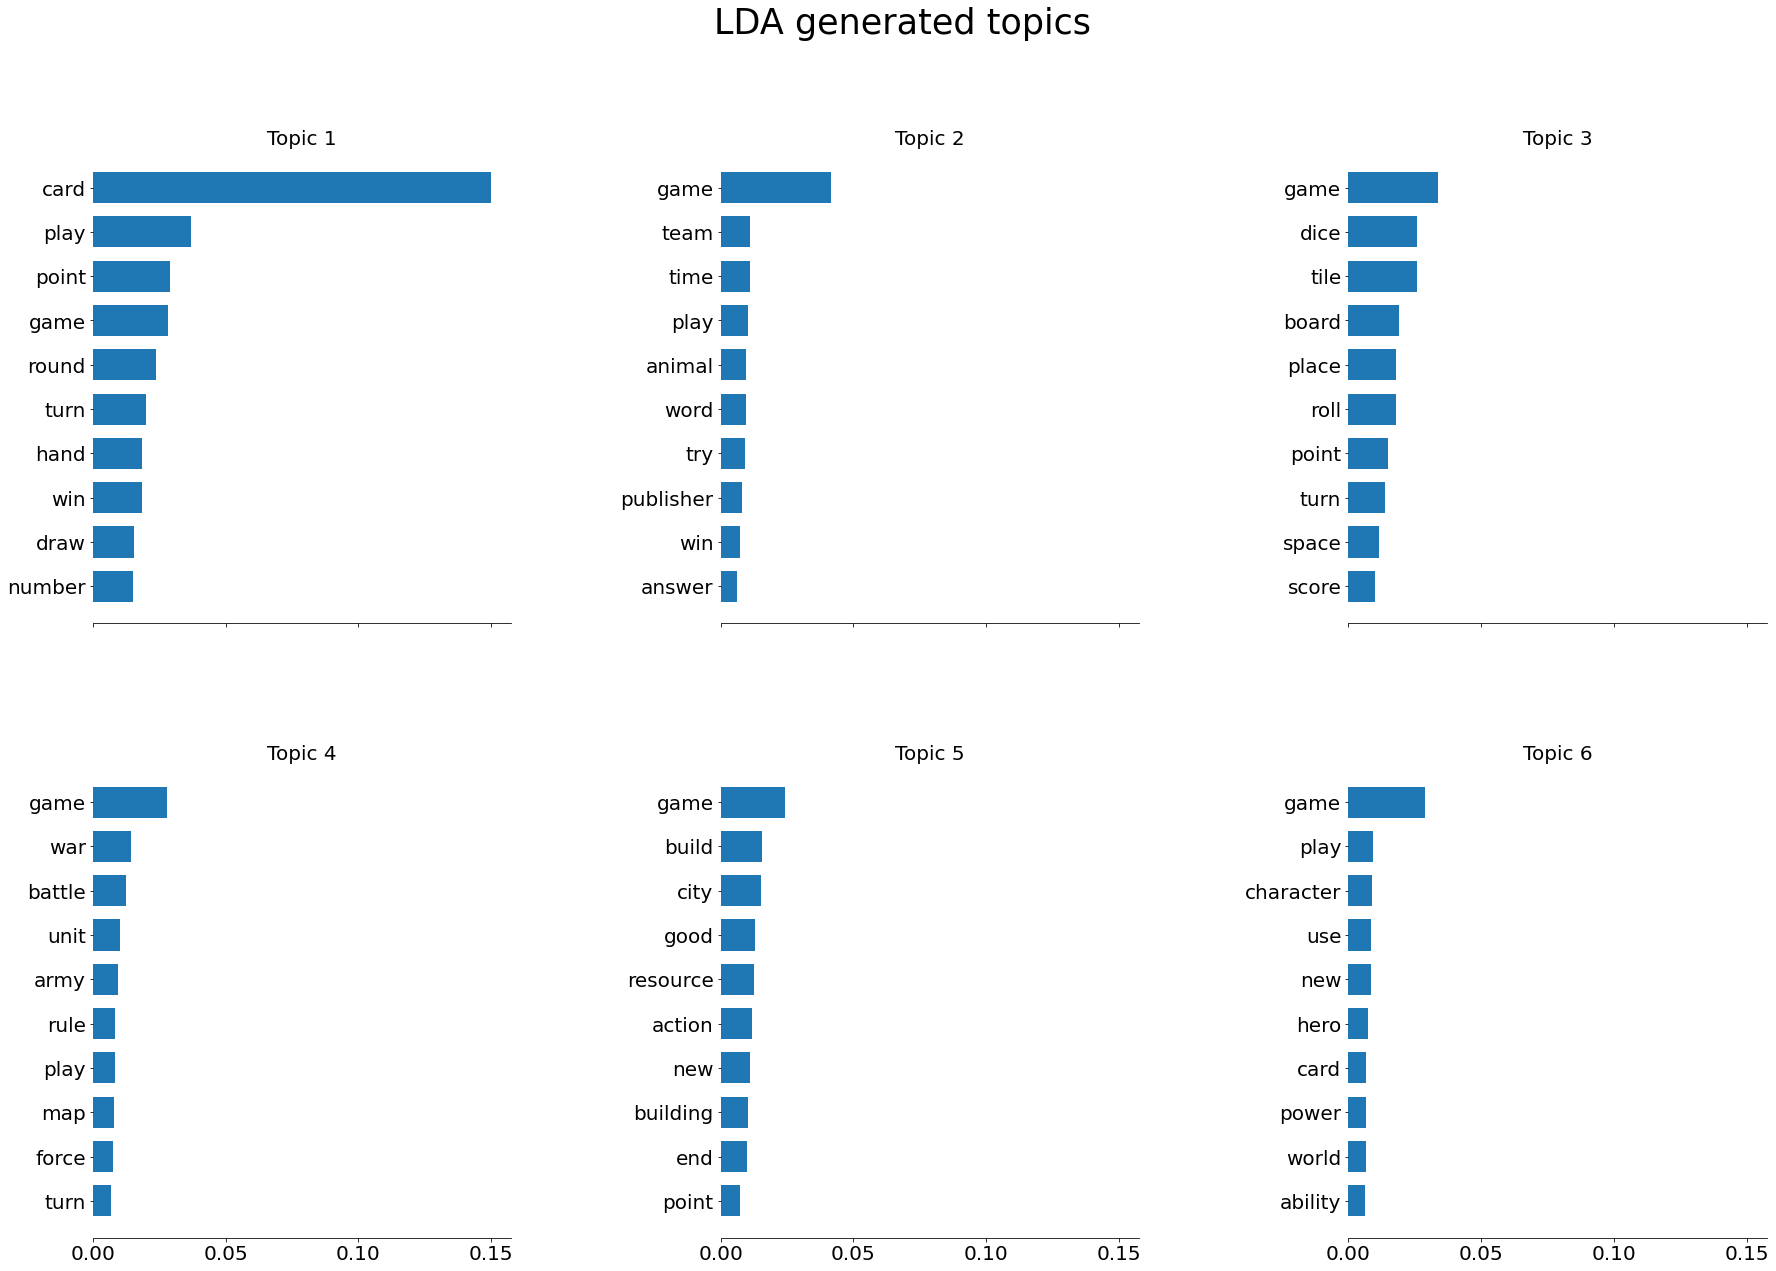

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(30, 20), sharex=True)
# fig.tight_layout(pad=0.005)
axes = axes.flatten()

for i in range(6):
    title='LDA generated topics'
    top_features = lda_topics_df[lda_topics_df.Topic==i+1]['Word']
    weights = lda_topics_df[lda_topics_df.Topic==i+1]['P']
    ax = axes[i]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {i+1}", fontdict={"fontsize": 20})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=35)
# plt.subplots_adjust(top=.09, bottom=0.01, wspace=0.90, hspace=0.3)
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, doc_term_mat, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



## Document Similarity

### Similarity Matrix Generation

In [ ]:
def sim_mat_gen(df, text_col,id_col):
    df = df[df['bgg_id']!=170984].sort_values('rank')
    desc_tokens = doc_text_preprocessing(df[text_col])
    token_dict = {x[0]:x[1] for x in list(zip(df[id_col],desc_tokens))}

    desc_dict = corpora.Dictionary()
    desc_corpus = [desc_dict.doc2bow(doc, allow_update=True) for doc in desc_tokens]

    temp_index = get_tmpfile("index")
    index = similarities.Similarity(temp_index, desc_corpus, num_features=len(desc_dict.token2id))

    sim_stack = []
    for sims in index:
      sim_stack.append(sims)

    games = dict(zip(df['name'], sim_stack))

    return sim_stack, token_dict, games, index

def sim_query(docs, priors=None, index=None, return_n=0,for_nlp=False):

    if for_nlp==True:
      desc_tokens = doc_text_preprocessing(docs['description'])
      desc_dict = corpora.Dictionary()
      desc_corpus = [desc_dict.doc2bow(doc, allow_update=True) for doc in desc_tokens]
      index.add_documents(desc_corpus)

      sim_stack = []
      for sims in index:
        sim_stack.append(sims)

      df = pd.concat([doc_train[doc_train['bgg_id']!=170984].sort_values('rank'), docs], ignore_index=True)
      sims = sim_stack[-len(docs):]
      for doc in docs['name']:
        col = 'doc_sim_' + doc
        df[col] = sims[0]
        sims.pop(0)
      return df

    else:
    
      desc_tokens = doc_text_preprocessing(docs['description'])
      token_dict = {x[0]:x[1] for x in list(zip(docs['name'],desc_tokens))}
      priors.update(token_dict)

      desc_dict = corpora.Dictionary()
      desc_corpus = [desc_dict.doc2bow(doc, allow_update=True) for doc in desc_tokens]
      index.add_documents(desc_corpus)

      sim_stack = []
      for sims in index:
        sim_stack.append(sims)

      names = list(doc_train['name'])+list(docs['name'])
      games = dict(zip(names, sim_stack))
      
      if return_n > 0:
        matches = {}
        for doc in docs['name']:
          lookup = dict(zip(names, games[doc]))
          matches.update({doc:[x for x in sorted(lookup.items(), key=lambda item: item[1], reverse=True)[0:return_n+1] if x[0]!=doc]})
        return matches
      else:
          return sim_stack, games

def sim_weight_gen(game,index=None):
  if index==None:
    mat,tokens,lookup,index = sim_mat_gen(doc_train,'description','name')
  
  if len(list(game))==1:
    if game['name']=='Oasis':
      query = doc_val[(doc_val['name']=='Oh My Goods!')|(doc_val['name']=='Oasis')]
    else:
      query = doc_val[(doc_val['name']==game)|(doc_val['name']=='Oasis')]
  else:
    query = doc_val[doc_val['name'].isin(game)]
  
  



In [ ]:
sim_mat, sim_tokens, sim_lookup, sim_index = sim_mat_gen(doc_train,'description','name')

/usr/local/lib/python3.7/dist-packages/gensim/similarities/docsim.py:518: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


In [ ]:
def sim_test(game, lookup_matrix, df=False):
    
    games = dict(zip(doc_train['name'], lookup_matrix))
    lookup = dict(zip(doc_train['name'], games[game]))
    top_matches = sorted(lookup, key=lookup.get, reverse=True)[1:11]
    
    if df == True:
      return top_matches, game_df[game_df['name'].isin([game] + top_matches)]

    else:
      game_words = Counter(lookup_dict[game]).most_common(15)

      top_pool = lookup_dict[game]
      for match in top_matches:
        top_pool.extend(lookup_dict[match])
      top_w = Counter(top_pool).most_common(15)
      
      return top_matches, (game_words, Counter(top_pool).most_common(15))

In [ ]:
#t1 = sim_query(doc_val[0:3],sim_tokens, sim_index, return_n=5)
t1 = sim_query(doc_val[0:3], index=sim_index,for_nlp=True)


In [ ]:
t1

num_votes    year  complexity  max_players  max_time  min_age  \
0        49619.0  2017.0      3.8725          4.0     120.0     14.0   
1        46143.0  2015.0      2.8307          4.0      60.0     13.0   
2        27490.0  2018.0      3.9048          4.0     120.0     14.0   
3        18628.0  2020.0      3.5880          4.0     120.0     14.0   
4        77368.0  2016.0      3.2473          5.0     120.0     12.0   
...          ...     ...         ...          ...       ...      ...   
13828     3018.0  2016.0      1.1707          6.0      45.0     12.0   
13829       30.0  2022.0      2.0000          6.0      45.0     10.0   
13830     2186.0  2004.0      2.3168          5.0      60.0     10.0   
13831     5095.0  2017.0      2.8671          5.0     100.0     12.0   
13832    10749.0  2015.0      2.2898          4.0      30.0     10.0   

       min_players  min_time  bayes_rating  cooperative  ...  \
0              1.0      60.0       8.49672          1.0  ...   
1              2.0      60.0       8.43552          1.0  ...   
2              2.0      60.0       8.42267          0.0  ...   
3              1.0      30.0       8.27009          1.0  ...   
4              1.0     120.0       8.26887          0.0  ...   
...            ...       ...           ...          ...  ...   
13828          2.0      30.0       4.66069          1.0  ...   
13829          2.0      20.0           NaN          0.0  ...   
13830          3.0      60.0       6.16239          0.0  ...   
13831          1.0      20.0       7.08724          0.0  ...   
13832          2.0      30.0       6.76381          0.0  ...   

      category_Video Game Theme category_Vietnam War category_Wargame  \
0                           0.0                  0.0              0.0   
1                           0.0                  0.0              0.0   
2                           0.0                  0.0              0.0   
3                           0.0                  0.0              0.0   
4                           0.0                  0.0              0.0   
...                         ...                  ...              ...   
13828                       1.0                  0.0              0.0   
13829                       0.0                  0.0              0.0   
13830                       0.0                  0.0              0.0   
13831                       0.0                  0.0              0.0   
13832                       0.0                  0.0              0.0   

       category_Word Game  category_World War I  category_World War II  \
0                     0.0                   0.0                    0.0   
1                     0.0                   0.0                    0.0   
2                     0.0                   0.0                    0.0   
3                     0.0                   0.0                    0.0   
4                     0.0                   0.0                    0.0   
...                   ...                   ...                    ...   
13828                 0.0                   0.0                    0.0   
13829                 0.0                   0.0                    0.0   
13830                 0.0                   0.0                    0.0   
13831                 0.0                   0.0                    0.0   
13832                 0.0                   0.0                    0.0   

       category_Zombies  doc_sim_Oasis  doc_sim_Nusfjord  doc_sim_Oh My Goods!  
0                   0.0       0.487612          0.404383              0.129259  
1                   0.0       0.090872          0.531061              0.373109  
2                   0.0       0.022575          0.085955              0.034078  
3                   0.0       0.026398          0.149598              0.031879  
4                   0.0       0.104472          0.140610              0.109340  
...                 ...            ...               ...                   ...  
13828               0.0       0.026980  

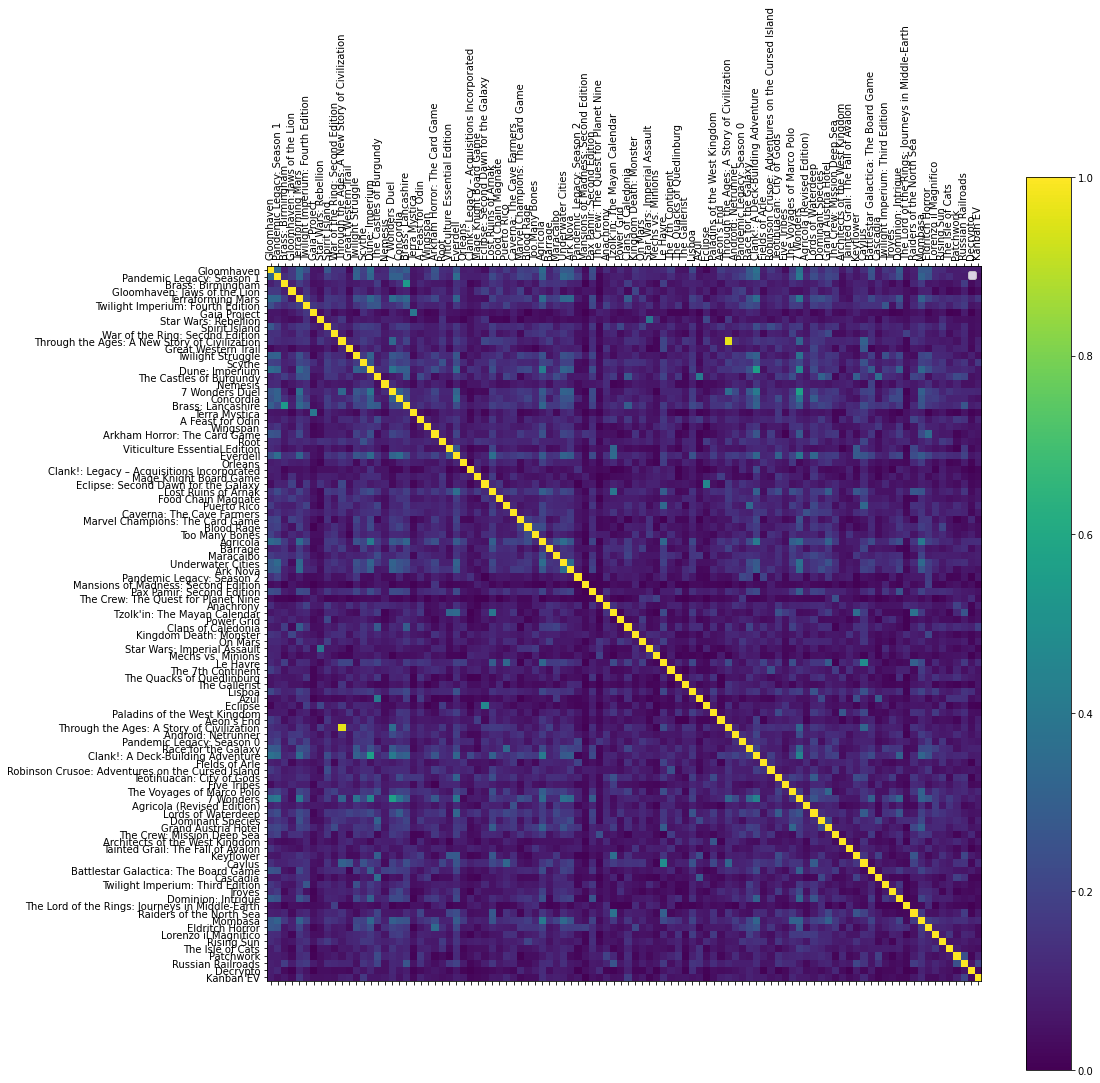

In [ ]:
plt.rcParams["figure.figsize"] = [16,16]
heatmap = plt.matshow([x[0:100] for x in sim_mat[0:100]])
labels=list(clust_df['name'][0:100])
plt.xticks(np.arange(0,100),labels=labels, rotation='vertical')
plt.yticks(np.arange(0,100),labels=labels)
plt.colorbar(heatmap)
plt.legend()
plt.show()

In [ ]:
test = pd.DataFrame(data=[x[0:5000] for x in sim_mat[0:5000]])
test.columns = doc_train['name'][0:5000]
test['label'] = list(doc_train['name'][0:5000])
edges = test.melt('label')
flt_edges = edges[(edges['value']>0.3) & (edges['label'] != edges['name'])]

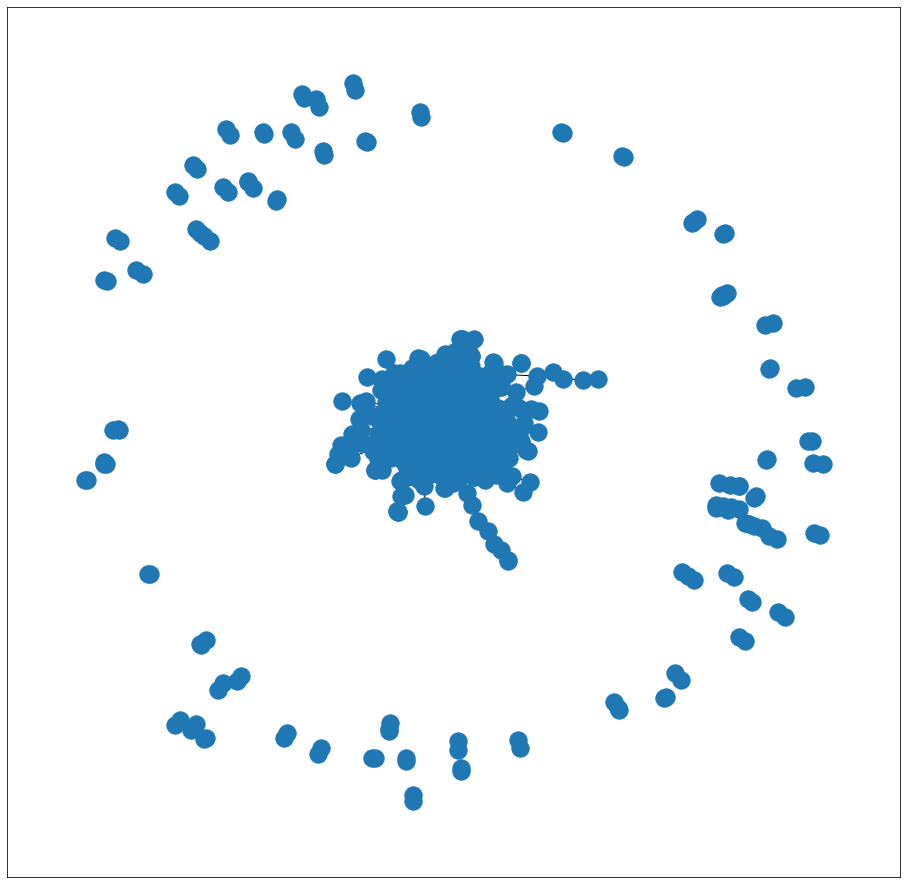

In [ ]:
G = nx.from_pandas_edgelist(flt_edges, source='label', target='name', edge_attr='value')
fig, ax = plt.subplots(figsize=(16,16))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax = ax)
nx.draw_networkx_edges(G, pos, ax=ax)

### Clustering

In [ ]:
def speccluster(matrix, n, clip=-1):
  clust = SpectralClustering(n_clusters = n,
                             affinity='precomputed',
                             random_state=RANDOM_STATE,
                             assign_labels='discretize'
                             ).fit(matrix)
  df = doc_train[doc_train['bgg_id']!=170984].sort_values('rank')
  df['labels'] = clust.labels_
  
  return df

In [ ]:
def knncluster(matrix, n, clip=-1):
  clust = SpectralClustering(n_clusters = n,
                             affinity='precomputed',
                             random_state=RANDOM_STATE,
                             assign_labels='discretize'
                             ).fit(matrix)
  df = doc_train[doc_train['bgg_id']!=170984].sort_values('rank')
  df['labels'] = clust.labels_
  
  return df

In [ ]:
label_analysis = speccluster(sim_mat,2)

In [ ]:
label_analysis.columns[10:15]

Index(['name', 'description', 'category', 'bgg_id', 'rank', 'mechanic_Acting'], dtype='object')

In [ ]:
label_analysis.groupby('labels').mean()#[col for col in label_analysis if col.startswith('category_')]]

num_votes         year  complexity  max_players    max_time  \
labels                                                                 
0       968.460746  2012.954721    2.175679     5.448227  105.202527   
1       987.703388  2013.148779    1.712653     6.469052   44.870907   

          min_age  min_players   min_time  bayes_rating  cooperative  ...  \
labels                                                                ...   
0       10.418626     1.926056  65.181584      5.731264     0.098046  ...   
1        9.972932     2.113193  31.996971      5.674470     0.069657  ...   

        category_Transportation  category_Travel  category_Trivia  \
labels                                                              
0                      0.024921         0.012519         0.020826   
1                      0.008329         0.008329         0.030286   

        category_Video Game Theme  category_Vietnam War  category_Wargame  \
labels                                                                      
0                        0.018720              0.003510          0.187902   
1                        0.019686              0.000189          0.037479   

        category_Word Game  category_World War I  category_World War II  \
labels                                                                    
0                 0.015327              0.011115               0.060372   
1                 0.024797              0.003407               0.009843   

        category_Zombies  
labels                    
0               0.012636  
1               0.010979  

[2 rows x 291 columns]

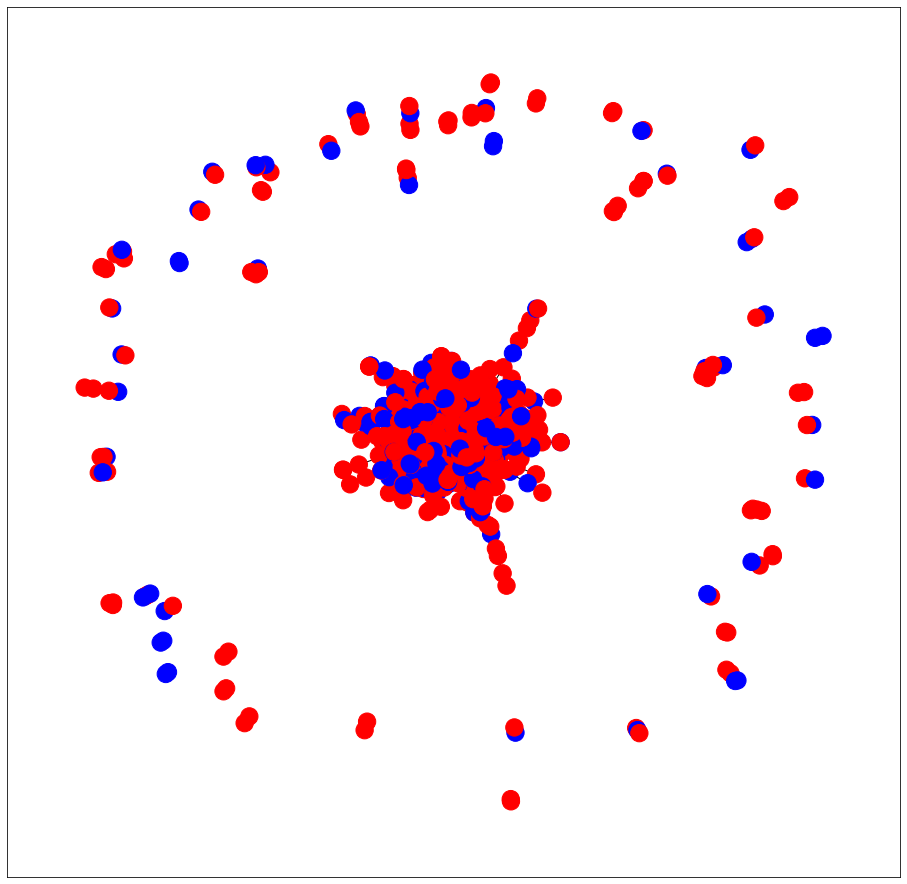

In [ ]:
test = pd.DataFrame(data=[x[0:5000] for x in sim_mat[0:5000]])
test.columns = doc_train[doc_train['bgg_id']!=170984].sort_values('rank')['name'][0:5000]
test['label'] = list(doc_train[doc_train['bgg_id']!=170984].sort_values('rank')['name'][0:5000])
edges = test.melt('label')
flt_edges = edges[(edges['value']>0.3) & (edges['label'] != edges['name'])]

color_state_map = {0: 'red', 1: 'blue'}
clust = list(label_analysis['labels'][0:5000])

G = nx.from_pandas_edgelist(flt_edges, source='label', target='name', edge_attr='value')
fig, ax = plt.subplots(figsize=(16,16))
pos = nx.spring_layout(G)
nx.set_node_attributes(G, dict(zip(G.nodes(), clust)), 'clust')
nx.draw_networkx_nodes(G, pos, ax = ax, node_color=[color_state_map[node[1]['clust']] for node in G.nodes(data=True)])
nx.draw_networkx_edges(G, pos, ax=ax)

In [ ]:
G.nodes()['Principato']

{}

In [ ]:
test_mat = [x[0:5000] for x in sim_stack[0:5000]]

scores = {}
for k in np.arange(1000,1500,100):
  _, chs = speccluster(test_mat,k)
  scores[k] = chs

In [ ]:
scores

{1000: 2.6832932909892215,
 1100: 2.6575638002191178,
 1200: 2.450228884719573,
 1300: 2.3871451676919047,
 1400: 2.4233036788064197}

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

for x in np.arange(0,8):
  fig.add_trace(go.Histogram(x=test8[test8['labels']==x]['bayes_rating']))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.6)
fig.show()

In [ ]:
def sim_test(game, df=False):
    
    games = dict(zip(clust_df['name'], sim_stack))
    lookup = dict(zip(clust_df['name'], games[game]))
    top_matches = sorted(lookup, key=lookup.get, reverse=True)[1:11]
    
    if df == True:
      return top_matches, game_df[game_df['name'].isin([game] + top_matches)]

    else:
      game_words = Counter(lookup_dict[game]).most_common(15)

      top_pool = lookup_dict[game]
      for match in top_matches:
        top_pool.extend(lookup_dict[match])
      top_w = Counter(top_pool).most_common(15)
      
      return top_matches, (game_words, Counter(top_pool).most_common(15))

In [ ]:
top, x = sim_test('Terraforming Mars')
x

([('card', 11),
  ('project', 6),
  ('production', 5),
  ('terraform', 4),
  ('temperature', 4),
  ('oxygen', 4),
  ('ocean', 4),
  ('terraforming', 4),
  ('resource', 4),
  ('tile', 4),
  ('phase', 4),
  ('corporation', 3),
  ('raise', 3),
  ('compete', 3),
  ('different', 3)],
 [('card', 316),
  ('resource', 44),
  ('food', 42),
  ('phase', 39),
  ('point', 33),
  ('project', 30),
  ('turn', 28),
  ('take', 27),
  ('character', 25),
  ('1', 24),
  ('round', 23),
  ('number', 23),
  ('action', 21),
  ('victory', 19),
  ('play', 18)])

#Number of Votes Regression

year  complexity  max_players  max_time   min_age  \
year                   1.000000    0.066705     0.007197  0.004985  0.135479   
complexity             0.066705    1.000000    -0.098646  0.240710  0.466896   
max_players            0.007197   -0.098646     1.000000 -0.013220  0.002187   
max_time               0.004985    0.240710    -0.013220  1.000000  0.100274   
min_age                0.135479    0.466896     0.002187  0.100274  1.000000   
...                         ...         ...          ...       ...       ...   
category_Wargame      -0.099327    0.397417    -0.060574  0.210985  0.189787   
category_Word Game    -0.042406   -0.116365     0.055096 -0.018778 -0.020566   
category_World War I  -0.026665    0.072864    -0.014157  0.074786  0.047727   
category_World War II -0.056165    0.232231    -0.035972  0.178037  0.103396   
category_Zombies       0.011115    0.011069    -0.006549 -0.004889  0.049543   

                       min_players  min_time  cooperative  mechanic_Acting  \
year                     -0.180729 -0.057486     0.187652        -0.024906   
complexity               -0.197283  0.222023     0.061479        -0.098821   
max_players               0.089480 -0.017052     0.008154         0.063688   
max_time                 -0.047418  0.587232     0.005567        -0.006917   
min_age                  -0.008680  0.097323     0.093367         0.029738   
...                            ...       ...          ...              ...   
category_Wargame         -0.139517  0.198902    -0.085130        -0.044537   
category_Word Game        0.092472 -0.018679    -0.015342         0.093790   
category_World War I     -0.033858  0.120452    -0.018920        -0.010352   
category_World War II    -0.093318  0.143400    -0.035701        -0.023792   
category_Zombies         -0.039869 -0.003959     0.116283        -0.012603   

                       mechanic_Action Drafting  ...  category_Transportation  \
year                                   0.033915  ...                 0.009562   
complexity                             0.053325  ...                 0.104085   
max_players                           -0.004589  ...                -0.010458   
max_time                               0.002363  ...                 0.005184   
min_age                                0.026519  ...                 0.027476   
...                                         ...  ...                      ...   
category_Wargame                      -0.009212  ...                -0.046093   
category_Word Game                    -0.006711  ...                -0.018974   
category_World War I                  -0.004351  ...                -0.012303   
category_World War II                 -0.010000  ...                -0.022478   
category_Zombies                      -0.005297  ...                -0.014977   

                       category_Travel  category_Trivia  \
year                          0.009737        -0.107012   
complexity                    0.003301        -0.124077   
max_players                  -0.007628         0.092808   
max_time                     -0.004850        -0.016537   
min_age                      -0.020249         0.046829   
...                                ...              ...   
category_Wargame             -0.041194        -0.060160   
category_Word Game           -0.009385         0.080036   
category_World War I         -0.009575        -0.014327   
category_World War II        -0.022006        -0.032927   
category_Zombies             -0.004885        -0.017441   

                       category_Video Game Theme  category_Vietnam War  \
year                                    0.043816             -0.004653   
complexity                              0.030545              0.051037   
max_players                            -0.009862             -0.013193   
max_time                               -0.006166              0.024791   
min_age                                 0.024776              0.022380   
...

# Older version of functions

In [ ]:
game_df = game_df[game_df['year'] >= 2000]
print(game_df.shape)
# train_X, test_df = train_test_split(game_df,random_state=RANDOM_STATE)
print(f'train size: {len(train_df)}, test size: {len(test_df)}')
# 80% 10% 10% split of train, valid, and test sets
# train_df, valid_df, test_df = np.split(game_df.sample(frac=1, random_state=RANDOM_STATE),[int(.8*len(game_df)), int(.9*len(game_df))])
# print(f'train size: {len(train_df)}, valid size: {len(valid_df)}, test size: {len(test_df)}')

(17289, 33244)


ValueError: ignored

### text preprocessing approach 1

In [ ]:
docs_train = game_df[game_df['description'].isna()][['name','description','category']]

In [ ]:
#descriptions=docs_train[['name','description','category']].copy()
descriptions=docs_train[~docs_train['description'].isna()][['name','description','category']]
def text_norm(text):
    """text processing steps"""
    try:
      stop_words=set(stopwords.words('english'))
      stop_words_spa=set(stopwords.words('spanish'))
      lemmatizer=WordNetLemmatizer()
      punctuation_exclusion=set(string.punctuation)
      remove_stopwords=' '.join([word for word in text.lower().split() if word not in stop_words])
      remove_stopwords=' '.join([word for word in remove_stopwords.split() if word not in stop_words_spa])
      remove_punctuation=''.join([l for l in remove_stopwords if l not in punctuation_exclusion])
      norm_text=' '.join([lemmatizer.lemmatize(word) for word in remove_punctuation.split()])
      tokenize_text=norm_text.split()
    except:
      tokenize_text=['no words']

    return tokenize_text

In [ ]:
descriptions['cleaned_descriptions']=descriptions['description'].apply(text_norm)
descriptions['cleaned_word_count']=descriptions['cleaned_descriptions'].apply(len)
display(descriptions.sort_values(by='cleaned_word_count',ascending=False).head())
print(f'total unique word: {len(set().union(*descriptions.cleaned_descriptions.tolist()))}')

name  \
87686  Robinson Crusoe: Escape from Despair Island   
55096                                     Red Code   
57517        Enemy Coast Ahead: The Dambuster Raid   
33846                     Nothing Gained But Glory   
61235                               Kombat Kittens   

                                             description  \
87686  “Never any young adventurer's misfortunes, I b...   
55096  Red Code instructions.\n\n1.0.\n\nWelcome to R...   
57517  Information from publishers game page\n\nOpera...   
33846  Nothing Gained But Glory will be the fifth vol...   
61235  Kombat Kittens Game Rules\n\nTHE GOAL\nCollect...   

                                                category  \
87686  ['Adventure', 'Card Game', 'Novel-based', 'Pir...   
55096  ['Card Game', 'Nautical', 'Wargame', 'World Wa...   
57517   ['Aviation / Flight', 'Wargame', 'World War II']   
33846                       ['Pike and Shot', 'Wargame']   
61235  ['Animals', 'Bluffing', 'Card Game', 'Fighting...   

                                    cleaned_descriptions  cleaned_word_count  
87686  [“never, young, adventurer, misfortune, believ...                1505  
55096  [red, code, instruction, 10, welcome, red, cod...                1108  
57517  [information, publisher, game, page, operation...                1036  
33846  [nothing, gained, glory, fifth, volume, award,...                1024  
61235  [kombat, kitten, game, rule, goal, collect, tr...                 998

total unique word: 76915


In [ ]:
# word distributions
from collections import Counter
import plotly.express as px
seq=descriptions.cleaned_descriptions.tolist()
counter=Counter(x for xs in seq for x in set(xs))
word_counts=pd.DataFrame.from_dict(counter,orient='index').reset_index()
word_counts.columns=['word','word_counts']
top_20_words=word_counts.sort_values(by='word_counts',ascending=False)[:20]
px.bar(top_20_words,x='word',y='word_counts',color='word_counts',title='Top 20 words in descriptions - after text processing')

In [ ]:
# may have to circle back on this, noticed there is foreign language in our corpus
# !pip install google_trans_new
# from google_trans_new import google_translator  

# detector = google_translator()  
# detect_result = detector.detect('中文字')
# print(detect_result)

In [ ]:
Old approach 2
#descriptions=docs_train[['name','description','category']].copy()
descriptions=docs_train[~docs_train['description'].isna()][['name','description','category']]
nlp=en_core_web_sm.load()
def doc_text_preprocessing(text):
  """text processing steps"""
  import re
  stop_words=set(stopwords.words('english'))
  stop_words_spa=set(stopwords.words('spanish'))
  custom_stop_words=['player','players','description']
  single_letter_pattern=r'\s+\w{1}\s+'
  single_letter_replace=lambda c: re.sub(single_letter_pattern,'',c)
  other_replace=lambda c: re.sub(r'\n|-|—','',c)
  to_lower_func=lambda c: c.lower()

  lemma_text=[token.lemma_ for token in nlp(text)]
  lemma_text=' '.join(lemma_text)
  tokenize_text=preprocess_string(lemma_text,[remove_stopwords,strip_numeric,strip_punctuation,strip_tags,
                                        strip_multiple_whitespaces,single_letter_replace,to_lower_func,other_replace])
  tokenize_text=[word for word in tokenize_text if word not in stop_words]
  tokenize_text=[word for word in tokenize_text if word not in stop_words_spa]
  tokenize_text=[word for word in tokenize_text if word not in custom_stop_words]

  return tokenize_text

In [ ]:
descriptions['cleaned_descriptions']=descriptions['description'].apply(doc_text_preprocessing)
descriptions['cleaned_word_count']=descriptions['cleaned_descriptions'].apply(len)
display(descriptions.sort_values(by='cleaned_word_count',ascending=False).head())
display(descriptions.head(2))
print(f'total unique word: {len(set().union(*descriptions.cleaned_descriptions.tolist()))}')

name  \
87686  Robinson Crusoe: Escape from Despair Island   
57517        Enemy Coast Ahead: The Dambuster Raid   
33846                     Nothing Gained But Glory   
55096                                     Red Code   
42066                              Next War: Korea   

                                             description  \
87686  “Never any young adventurer's misfortunes, I b...   
57517  Information from publishers game page\n\nOpera...   
33846  Nothing Gained But Glory will be the fifth vol...   
55096  Red Code instructions.\n\n1.0.\n\nWelcome to R...   
42066  Sixty years of tense, uneasy peace are shatter...   

                                                category  \
87686  ['Adventure', 'Card Game', 'Novel-based', 'Pir...   
57517   ['Aviation / Flight', 'Wargame', 'World War II']   
33846                       ['Pike and Shot', 'Wargame']   
55096  ['Card Game', 'Nautical', 'Wargame', 'World Wa...   
42066                      ['Modern Warfare', 'Wargame']   

                                    cleaned_descriptions  cleaned_word_count  
87686  [young, adventurermisfortunebelieve, begin, so...                1202  
57517  [information, publisher, game, page, operation...                 879  
33846  [gained, glory, fifth, volume, award, win, mus...                 875  
55096  [red, code, instruction, welcome, red, code, b...                 865  
42066  [year, tense, uneasy, peace, shatter, korean, ...                 812

name                                        description  \
340  Corruption  Described by the designer as a cross between D...   
413   Taj Mahal  Northwest India at the beginning of the 18th c...   

                      category  \
340  ['Bluffing', 'Card Game']   
413  ['Bluffing', 'Political']   

                                  cleaned_descriptions  cleaned_word_count  
340  [designer, cross, doris, frankbanana, republic...                  48  
413  [northwest, india, beginning, th, century, rul...                 137

total unique word: 69695


#Regression - Rating

##Feature Selection Tuning

In [ ]:
list(itertools.combinations(['game_type_','category_','mechanic_','family_','artist_','designer_','publisher_'],2))

[('game_type_', 'category_'),
 ('game_type_', 'mechanic_'),
 ('game_type_', 'family_'),
 ('game_type_', 'artist_'),
 ('game_type_', 'designer_'),
 ('game_type_', 'publisher_'),
 ('category_', 'mechanic_'),
 ('category_', 'family_'),
 ('category_', 'artist_'),
 ('category_', 'designer_'),
 ('category_', 'publisher_'),
 ('mechanic_', 'family_'),
 ('mechanic_', 'artist_'),
 ('mechanic_', 'designer_'),
 ('mechanic_', 'publisher_'),
 ('family_', 'artist_'),
 ('family_', 'designer_'),
 ('family_', 'publisher_'),
 ('artist_', 'designer_'),
 ('artist_', 'publisher_'),
 ('designer_', 'publisher_')]

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df, ['publisher_'],
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train':regr.score(X_train, y_train),'test':regr.score(X_test, y_test)}
s

{'train': 0.944835897155196, 'test': 0.5963512568922988}

In [ ]:
test = game_df[game_df.columns[game_df.columns.str.startswith('publisher_')].tolist()]
len(test.columns)

6772

In [ ]:
scores = {}
for comb in list(itertools.combinations(['game_type_','category_','mechanic_','family_','artist_','designer_','publisher_'],2)):
  X_train, X_test, y_train, y_test = feature_train(
    game_df,[comb[0],comb[1]], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)
  regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
  y_pred_rf = regr.predict(X_test)
  s = {'train' + comb[0] + comb[1]:regr.score(X_train, y_train),'test'+comb[0]+comb[1]:regr.score(X_test, y_test)}
  scores.update(s)
scores

{'traingame_type_category_': 0.9252030493591074,
 'testgame_type_category_': 0.4745986326144297,
 'traingame_type_mechanic_': 0.9403010148812609,
 'testgame_type_mechanic_': 0.5895400502063314,
 'traingame_type_family_': 0.9401568653484877,
 'testgame_type_family_': 0.5847895639615672,
 'traingame_type_artist_': 0.9298561785006857,
 'testgame_type_artist_': 0.4863516446367703,
 'traingame_type_designer_': 0.9310222203902683,
 'testgame_type_designer_': 0.49563277783940896,
 'traingame_type_publisher_': 0.9542948684162674,
 'testgame_type_publisher_': 0.6703977117293904,
 'traincategory_mechanic_': 0.9261589476917298,
 'testcategory_mechanic_': 0.46653101699428556,
 'traincategory_family_': 0.9263969777862867,
 'testcategory_family_': 0.47136155553090964,
 'traincategory_artist_': 0.9134505382524365,
 'testcategory_artist_': 0.37690540592517763,
 'traincategory_designer_': 0.9168878480820396,
 'testcategory_designer_': 0.38712707278753855,
 'traincategory_publisher_': 0.9446534435394559

##RandomForest

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train' + comb[0] + comb[1]:regr.score(X_train, y_train),'test'+comb[0]+comb[1]:regr.score(X_test, y_test)}

In [ ]:
s

{'traindesigner_publisher_': 0.9568815458141117,
 'testdesigner_publisher_': 0.6979638175075431}

In [ ]:
param_grid = {  'bootstrap': [True], 'max_depth': [100,150, 200, 250], 'max_features':["auto",'sqrt'], 'n_estimators': [ 100, 200, 250]}
regr = RandomForestRegressor( random_state= RANDOM_STATE)
g_search = GridSearchCV(estimator = regr, param_grid = param_grid, cv=5,  n_jobs = -1, verbose = 0, return_train_score=True)

g_search.fit(X_train, y_train)
print('Grid best parameter (max. accuracy): ', g_search.best_params_)
print('Grid best score (accuracy): ', g_search.best_score_)

Grid best parameter (max. accuracy):  {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 250}
Grid best score (accuracy):  0.6848959382912448


In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)
regr = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}

In [ ]:
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9574906711484091, 'test_gtpmf': 0.7010929029506856}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)
regr = RandomForestRegressor(n_estimators=400, max_depth=100, random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}

In [ ]:
s

{'train_gtpmf': 0.9576921153370705, 'test_gtpmf': 0.7023935488997066}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_','designer'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}


In [ ]:
s

{'train_gtpmf': 0.9568608026692741, 'test_gtpmf': 0.6986307307543917}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_','designer','category'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9565784552148677, 'test_gtpmf': 0.7000540607245691}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)

In [ ]:
svd=TruncatedSVD(n_components=500,n_iter=8,random_state=RANDOM_STATE)
svd.fit(X_train)
svd_X=svd.transform(X_train)
svd_X_test=svd.transform(X_test)
svddf_X=pd.DataFrame(svd_X)
svddf_XT=pd.DataFrame(svd_X_test)

print(f'SVD number of components: 500, total variance explained: {np.cumsum(svd.explained_variance_ratio_)[-1]}')

SVD number of components: 500, total variance explained: 0.99998941993399


In [ ]:
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(svddf_X, y_train)
y_pred_rf = regr.predict(svddf_XT)
s = {'train_gtpmf':regr.score(svddf_X, y_train),'test_gtpmf':regr.score(svddf_XT, y_test)}
s

{'train_gtpmf': 0.9469597185038501, 'test_gtpmf': 0.6094299974389805}

In [ ]:
regr = RandomForestRegressor(n_estimators=1000,
                             random_state=RANDOM_STATE, 
                             n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9585145405229688, 'test_gtpmf': 0.7016277472278836}

##DecTree and SVR Tests

In [ ]:
regr = DecisionTreeRegressor(max_depth=7,random_state=RANDOM_STATE).fit(X_train,y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.6120446030201504, 'test_gtpmf': 0.5228186801823281}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=True)

regr = SVR(C=1.0, epsilon=0.2).fit(X_train,y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8643617654656999, 'test_gtpmf': 0.5882210704555297}

##HistGBR

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)

regr = HistGradientBoostingRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8312520128942249, 'test_gtpmf': 0.7361316304261771}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_','designer','category'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)

regr = HistGradientBoostingRegressor(learning_rate=0.1,random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8345798910416079, 'test_gtpmf': 0.7395142185918862}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)



In [ ]:
regr = HistGradientBoostingRegressor(max_iter=150,random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8553491791858423, 'test_gtpmf': 0.7422232081188826}

In [ ]:
regr = HistGradientBoostingRegressor(max_iter=250,random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8783419020906632, 'test_gtpmf': 0.7464600735070855}

In [ ]:
regr = HistGradientBoostingRegressor(max_iter=250,early_stopping=False,random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8926936619703962, 'test_gtpmf': 0.7507854374271375}

In [ ]:
regr = HistGradientBoostingRegressor(max_iter=250,max_leaf_nodes=30,early_stopping=False,random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8901113161539839, 'test_gtpmf': 0.7523492463430802}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)

In [ ]:
regr = HistGradientBoostingRegressor(max_iter=350,max_leaf_nodes=30,early_stopping=False,random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9080599779854819, 'test_gtpmf': 0.7549883101460855}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_','family_'], 
    targ='bayes_rating',
    drop=['name','description','category','bgg_id','rank','num_votes'],
    scale=False)



In [ ]:
regr = HistGradientBoostingRegressor(max_iter=250,max_leaf_nodes=30,early_stopping=False,random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8948114853134027, 'test_gtpmf': 0.7506596426941211}

##AdaBoost

In [ ]:
ada = AdaBoostRegressor(base_estimator=regr, n_estimators=5, random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = ada.predict(X_test)
s = {'train_gtpmf':ada.score(X_train, y_train),'test_gtpmf':ada.score(X_test, y_test)}
s

{'train_gtpmf': 0.9217813961258761, 'test_gtpmf': 0.7620070708179845}

In [ ]:
ada = AdaBoostRegressor(base_estimator=regr, n_estimators=10, random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = ada.predict(X_test)
s = {'train_gtpmf':ada.score(X_train, y_train),'test_gtpmf':ada.score(X_test, y_test)}
s

{'train_gtpmf': 0.9322100158568691, 'test_gtpmf': 0.7654847193595449}

In [ ]:
ada = AdaBoostRegressor(base_estimator=regr, n_estimators=15, random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = ada.predict(X_test)
s = {'train_gtpmf':ada.score(X_train, y_train),'test_gtpmf':ada.score(X_test, y_test)}
s

{'train_gtpmf': 0.9361653035817208, 'test_gtpmf': 0.7677205445679731}

In [ ]:
ada = AdaBoostRegressor(base_estimator=regr, random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = ada.predict(X_test)
s = {'train_gtpmf':ada.score(X_train, y_train),'test_gtpmf':ada.score(X_test, y_test)}
s

{'train_gtpmf': 0.9390667236163441, 'test_gtpmf': 0.7641811474028163}

In [ ]:
list(ada.staged_score(X_test, y_test))


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  "X does not have valid feature names, but"


[0.7383655205641833,
 0.7383655205641833,
 0.7558682238507951,
 0.7547542561449158,
 0.7620070708179845,
 0.7647428296364797,
 0.7652249096582128,
 0.7652958865202986,
 0.764997535036799,
 0.7654847193595449,
 0.7659401428345671,
 0.766840936507584,
 0.7673118172517713,
 0.7679968019801361,
 0.7677205445679731,
 0.7677197216993253,
 0.7669377118417697,
 0.7674625864720175,
 0.7672930420365142,
 0.7664824167326393,
 0.7666424894191133,
 0.7666790780077813,
 0.7661912160046052,
 0.7665979595938541,
 0.7659167722540343,
 0.7666148807692312,
 0.7658669418179245,
 0.76573861448394,
 0.7658506663293753,
 0.7651347924963835,
 0.7652174964706983,
 0.7649724815447108,
 0.7649034141876873,
 0.7650477313155996,
 0.7650100846666505,
 0.764937093565226,
 0.7644996237618564,
 0.7644779104572353,
 0.7643303063709513,
 0.7647226196788275,
 0.7645960241021302,
 0.7650905490903313,
 0.7645988380632096,
 0.7644763083246026,
 0.7644767320154805,
 0.7646093702220595,
 0.7643474075315184,
 0.764655353411914

#Regression - votes

In [ ]:
scores = {}
for comb in list(itertools.combinations(['game_type_','category_','mechanic_','family_','artist_','designer_','publisher_'],2)):
  X_train, X_test, y_train, y_test = feature_train(
    game_df,[comb[0],comb[1]], 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=False)
  regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
  y_pred_rf = regr.predict(X_test)
  s = {'train' + comb[0] + comb[1]:regr.score(X_train, y_train),'test'+comb[0]+comb[1]:regr.score(X_test, y_test)}
  scores.update(s)
scores

{'traingame_type_category_': 0.8649731675616581,
 'testgame_type_category_': 0.004504894021895356,
 'traingame_type_mechanic_': 0.8808423586686032,
 'testgame_type_mechanic_': 0.2733667075603986,
 'traingame_type_family_': 0.8956437306413497,
 'testgame_type_family_': 0.20662558634471095,
 'traingame_type_artist_': 0.8727256587600145,
 'testgame_type_artist_': 0.11385224652280523,
 'traingame_type_designer_': 0.8507722123164392,
 'testgame_type_designer_': -0.10741476017333906,
 'traingame_type_publisher_': 0.9354659609091334,
 'testgame_type_publisher_': 0.5622438451387685,
 'traincategory_mechanic_': 0.8831437023958811,
 'testcategory_mechanic_': 0.2533259675483315,
 'traincategory_family_': 0.8900302792958018,
 'testcategory_family_': 0.22207689622862203,
 'traincategory_artist_': 0.8649355851175047,
 'testcategory_artist_': 0.0998381630227877,
 'traincategory_designer_': 0.8551060816544103,
 'testcategory_designer_': 0.007949526321423317,
 'traincategory_publisher_': 0.937850590791

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['publisher_'], 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=False)
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9378962103567433, 'test_gtpmf': 0.550771402298955}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['publisher_','game_type_','mechanic_'], 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=False)
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.936948882469682, 'test_gtpmf': 0.5829127426666476}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['publisher_','game_type_','mechanic_','family_'], 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=False)
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9371780649366773, 'test_gtpmf': 0.567201862265634}

In [ ]:
regr = HistGradientBoostingRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8508740674936048, 'test_gtpmf': 0.5462904983953252}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['game_type_','publisher_','mechanic_'], 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=True)

regr = SVR(C=1.0, epsilon=0.2).fit(X_train,y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': -0.020650355920846852, 'test_gtpmf': -0.02340019431535123}

In [ ]:
regr = HistGradientBoostingRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8508740674936048, 'test_gtpmf': 0.5523305816918411}

In [ ]:
regr = RandomForestRegressor(n_estimators=150,random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9404368943662764, 'test_gtpmf': 0.587828269806445}

In [ ]:
regr = RandomForestRegressor(n_estimators=250,random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9393673454563687, 'test_gtpmf': 0.5925733816310035}

In [ ]:
regr = RandomForestRegressor(n_estimators=500,random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9411052054933594, 'test_gtpmf': 0.5890527235176237}

In [ ]:
svd=TruncatedSVD(n_components=500,n_iter=8,random_state=RANDOM_STATE)
svd.fit(X_train)
svd_X=svd.transform(X_train)
svd_X_test=svd.transform(X_test)
svddf_X=pd.DataFrame(svd_X)
svddf_XT=pd.DataFrame(svd_X_test)

print(f'SVD number of components: 500, total variance explained: {np.cumsum(svd.explained_variance_ratio_)[-1]}')

SVD number of components: 500, total variance explained: 0.8859612831682833


In [ ]:
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(svddf_X, y_train)
y_pred_rf = regr.predict(svddf_XT)
s = {'train_gtpmf':regr.score(svddf_X, y_train),'test_gtpmf':regr.score(svddf_XT, y_test)}
s

{'train_gtpmf': 0.9405172202686043, 'test_gtpmf': 0.569707448389304}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['publisher_','game_type_','mechanic_'], 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=False)
regr = HistGradientBoostingRegressor(max_iter = 250, random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8508740674936048, 'test_gtpmf': 0.5462904983953252}

In [ ]:
regr = RandomForestRegressor(n_estimators=250,min_samples_split=3,random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9322013618195727, 'test_gtpmf': 0.58943809622547}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df, 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=False)

In [ ]:
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.8598535786328685, 'test_gtpmf': -0.022973061591149646}

In [ ]:
regr = GradientBoostingRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.1522172838670579, 'test_gtpmf': 0.060929308645914726}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df, ['publisher_'],
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=False)

In [ ]:
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9378962103567433, 'test_gtpmf': 0.550771402298955}

In [ ]:
X_train, X_test, y_train, y_test = feature_train(
    game_df,['publisher_','game_type_','mechanic_'], 
    targ='num_votes',
    drop=['name','description','category','bgg_id','rank','bayes_rating'],
    scale=False)
regr = RandomForestRegressor(n_estimators=250, random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
s = {'train_gtpmf':regr.score(X_train, y_train),'test_gtpmf':regr.score(X_test, y_test)}
s

{'train_gtpmf': 0.9393187496722922, 'test_gtpmf': 0.5905036446850893}